$$\textbf{The Convolutional neural networks (CNN) for Multi-step Exchange Rate Forecasting}$$

# 1. Preparing Problem

## 1.1. Loading Libraries 

In [2]:
# univariate multi-step cnn for the exchange rate dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


## 1.2. Creating several neccessary functions

### 1.2.1. Spliting a univariate dataset into train/test sets

In [10]:
def split_dataset(data):
# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

### 1.2.2. Evaluating one or more weekly forecasts against expected values

In [11]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

### 1.2.3. Summarizing scores

In [12]:
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

### 1.2.4. Converting history into inputs and outputs

In [13]:
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

### 1.2.5. Training the model

In [14]:
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(10, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

### 1.2.6. Making a forecast

In [15]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

### 1.2.7. Evaluating a single model

In [16]:
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# 2. Loading data

## 2.1. Loading data from the excel file

In [18]:
import os
os.getcwd()

'/Users/phuong/Documents/Com 1/Modelling Division Riksbank/Riksbank AI Models'

In [25]:
import pandas as pd
dataset=pd.read_excel('REER_database_ver4Oct2019.xls',sheet_name='NEER_MONTHLY_38')#,names='NEER_38_EA12')

In [27]:
dataset.head(5)

,Updated: 4 October 2019,NEER_38_AE,NEER_38_AF,NEER_38_AG,NEER_38_AL,NEER_38_AM,NEER_38_AO,NEER_38_AR,NEER_38_AT,NEER_38_AU,...,NEER_38_US,NEER_38_UY,NEER_38_UZ,NEER_38_VC,NEER_38_VE,NEER_38_VN,NEER_38_WS,NEER_38_YE,NEER_38_ZA,NEER_38_ZM
0,1970M01,57.156914,NaN,183.744525,NaN,NaN,2.247103e+11,2.983147e+12,42.877602,109.399564,...,33.534947,4.288365e+06,NaN,108.402445,16095.610751,NaN,313.649440,NaN,796.789463,196322.665430
1,1970M02,57.184988,NaN,183.779676,NaN,NaN,2.247855e+11,2.985902e+12,42.886058,109.483793,...,33.575146,4.291790e+06,NaN,108.441118,16110.899527,NaN,313.707246,NaN,797.125459,196385.868239
2,1970M03,57.272265,NaN,183.878698,NaN,NaN,2.248182e+11,2.993236e+12,42.918261,109.802174,...,33.733378,4.301049e+06,NaN,108.534115,16134.644386,NaN,313.883152,NaN,798.244790,196581.336397
3,1970M04,57.395405,NaN,183.943819,NaN,NaN,2.249179e+11,2.999631e+12,42.935689,110.030140,...,33.774035,4.308912e+06,NaN,108.620210,16157.416348,NaN,314.228590,NaN,799.046375,196736.084909
4,1970M05,57.513002,NaN,184.023594,NaN,NaN,2.248868e+11,3.006233e+12,42.954601,110.251877,...,33.852790,4.317168e+06,NaN,108.712362,16181.236287,NaN,314.565166,NaN,799.882811,196910.612021


In [35]:
list(dataset)

['Updated: 4 October 2019',
 'NEER_38_AE',
 'NEER_38_AF',
 'NEER_38_AG',
 'NEER_38_AL',
 'NEER_38_AM',
 'NEER_38_AO',
 'NEER_38_AR',
 'NEER_38_AT',
 'NEER_38_AU',
 'NEER_38_AZ',
 'NEER_38_BA',
 'NEER_38_BB',
 'NEER_38_BD',
 'NEER_38_BE',
 'NEER_38_BF',
 'NEER_38_BG',
 'NEER_38_BH',
 'NEER_38_BI',
 'NEER_38_BJ',
 'NEER_38_BN',
 'NEER_38_BO',
 'NEER_38_BR',
 'NEER_38_BS',
 'NEER_38_BT',
 'NEER_38_BW',
 'NEER_38_BY',
 'NEER_38_BZ',
 'NEER_38_CA',
 'NEER_38_CD',
 'NEER_38_CF',
 'NEER_38_CG',
 'NEER_38_CH',
 'NEER_38_CI',
 'NEER_38_CL',
 'NEER_38_CM',
 'NEER_38_CN',
 'NEER_38_CO',
 'NEER_38_CR',
 'NEER_38_CV',
 'NEER_38_CY',
 'NEER_38_CZ',
 'NEER_38_DE',
 'NEER_38_DJ',
 'NEER_38_DK',
 'NEER_38_DM',
 'NEER_38_DO',
 'NEER_38_DZ',
 'NEER_38_EA12',
 'NEER_38_EC',
 'NEER_38_EE',
 'NEER_38_EG',
 'NEER_38_ES',
 'NEER_38_ET',
 'NEER_38_FI',
 'NEER_38_FJ',
 'NEER_38_FR',
 'NEER_38_GA',
 'NEER_38_GB',
 'NEER_38_GD',
 'NEER_38_GE',
 'NEER_38_GH',
 'NEER_38_GM',
 'NEER_38_GN',
 'NEER_38_GQ',
 'NEER_38_

In [37]:
NEER_EA12=dataset.NEER_38_EA12

In [39]:
NEER_EA12.head(5)

0    45.137171
1    45.171406
2    45.305644
3    45.361878
4    45.419130
Name: NEER_38_EA12, dtype: float64

In [53]:
len(NEER_EA12)

597

In [ ]:
# Generating a timedate from January 1970 to September 2019
import numpy as np
time=np.linspace(1970,2019,len(NEER_EA12))
time

## 2.2. Plotting data

Text(0.5, 0, 'Source: Bruegel Datasets \n https://bruegel.org/publications/datasets/real-effective-exchange-rates-for-178-countries-a-new-database/ ')

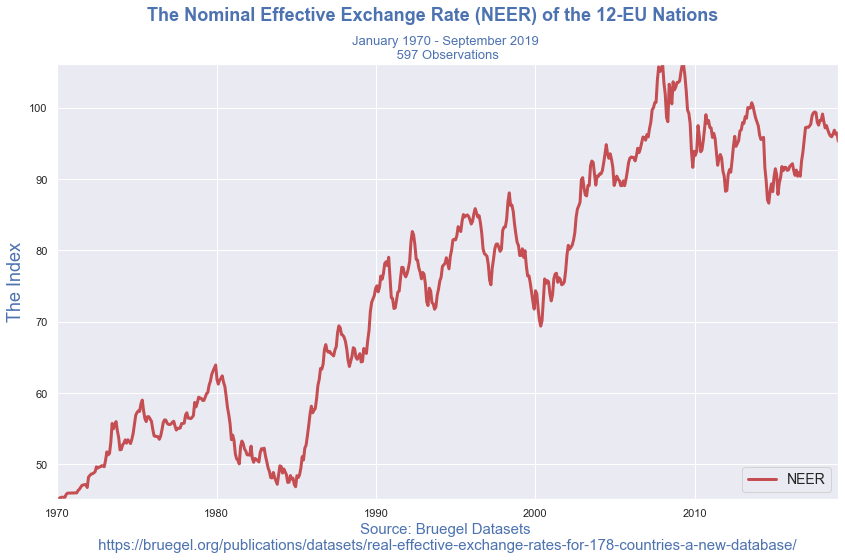

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig=plt.figure(figsize=(14,8))
plt.plot(time,NEER_EA12,LineWidth=3,Color='r',label='NEER')
#plt.plot(time,NEER_EA12,LineWidth=3,Color='r',label='NEER')
plt.autoscale(enable=True,axis='both',tight=True)
fig.suptitle('The Nominal Effective Exchange Rate (NEER) of the 12-EU Nations \n '
             ,fontsize=18,fontweight='bold',color='b')
plt.title('January 1970 - September 2019 \n 597 Observations '
          ,fontsize=13,fontweight='normal',color='b')
plt.ylabel('The Index',fontsize=18, color='b')
plt.legend(loc='lower right',fontsize=14)
plt.xlabel('Source: Bruegel Datasets \n https://bruegel.org/publications/datasets/real-effective-exchange-rates-for-178-countries-a-new-database/ ' ,
           fontsize=15,fontweight='ultralight',color='b')

## 2.3. Spliting data into train and test

In [70]:
train_size=int(len(NEER_EA12)*0.7)
test_size=len(NEER_EA12)-train_size
train, test=NEER_EA12[0:train_size], NEER_EA12[train_size:len(NEER_EA12)]

# 3. Training, evaluating model and get scores

In [144]:
def split_sequence(sequence, n_steps):
    X, y= list(), list()
    for i in range(len(sequence)):
        end_ix= i + n_steps
        if end_ix > len(sequence) -1:
            break
        seq_x, seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [145]:
n_steps=3

In [146]:
train_X, train_y=split_sequence(train, n_steps)

In [187]:
for i in range(len(train)):
    print(train_X[i], train_y[i])

[45.13717116 45.17140627 45.30564372] 45.36187771337168
[45.17140627 45.30564372 45.36187771] 45.419129886053014
[45.30564372 45.36187771 45.41912989] 45.38065530953173
[45.36187771 45.41912989 45.38065531] 45.389981630210166
[45.41912989 45.38065531 45.38998163] 45.80902455498871
[45.38065531 45.38998163 45.80902455] 45.972250916720746
[45.38998163 45.80902455 45.97225092] 45.983770155393536
[45.80902455 45.97225092 45.98377016] 45.98431475536801
[45.97225092 45.98377016 45.98431476] 45.989494354226245
[45.98377016 45.98431476 45.98949435] 45.99037139423326
[45.98431476 45.98949435 45.99037139] 45.99410544913864
[45.98949435 45.99037139 45.99410545] 46.00224004278686
[45.99037139 45.99410545 46.00224004] 46.013950082225286
[45.99410545 46.00224004 46.01395008] 46.33716842050584
[46.00224004 46.01395008 46.33716842] 46.51062372305984
[46.01395008 46.33716842 46.51062372] 46.804281928136774
[46.33716842 46.51062372 46.80428193] 47.07104229937799
[46.51062372 46.80428193 47.0710423 ] 47.

[75.82641003 75.18028125 77.52042937] 78.80486828587927
[75.18028125 77.52042937 78.80486829] 80.25296181211716
[77.52042937 78.80486829 80.25296181] 80.86607536495848
[78.80486829 80.25296181 80.86607536] 80.90784612453484
[80.25296181 80.86607536 80.90784612] 80.44515831303919
[80.86607536 80.90784612 80.44515831] 79.86408648705172
[80.90784612 80.44515831 79.86408649] 80.18695146940674
[80.44515831 79.86408649 80.18695147] 82.80970010103405
[79.86408649 80.18695147 82.8097001 ] 83.26536640928586
[80.18695147 82.8097001  83.26536641] 83.29258494620203
[82.8097001  83.26536641 83.29258495] 84.3852516532481
[83.26536641 83.29258495 84.38525165] 86.85007517696435
[83.29258495 84.38525165 86.85007518] 88.06868583616118
[84.38525165 86.85007518 88.06868584] 86.29267143799551
[86.85007518 88.06868584 86.29267144] 86.35545292074785
[88.06868584 86.29267144 86.35545292] 85.48343766354371
[86.29267144 86.35545292 85.48343766] 83.70396861751048
[86.35545292 85.48343766 83.70396862] 82.31033247

IndexError: index 414 is out of bounds for axis 0 with size 414

In [188]:
train

0      45.137171
1      45.171406
2      45.305644
3      45.361878
4      45.419130
         ...    
412    90.421713
413    90.383080
414    90.746473
415    90.728379
416    91.173592
Name: NEER_38_EA12, Length: 417, dtype: float64

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
#from tensorflow.keras.utils import np_utils

In [124]:
def baseline_model():
    # create model
    model=Sequential()
    model.add(Dense(8,input_dim=n_steps, activation='relu')) #kernel_initializer='normal',)
    model.add(Dense(1)) #, kernel_initializer='normal',activation='softmax'))
    # compile model
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [125]:
model=baseline_model()

In [127]:
model.fit(train_X, train_y,epochs=200,batch_size=2,verbose=2)

Train on 414 samples
Epoch 1/200
414/414 - 4s - loss: 1770.9849
Epoch 2/200
414/414 - 0s - loss: 6.8892
Epoch 3/200
414/414 - 0s - loss: 4.1389
Epoch 4/200
414/414 - 0s - loss: 4.2352
Epoch 5/200
414/414 - 0s - loss: 4.1628
Epoch 6/200
414/414 - 0s - loss: 4.1886
Epoch 7/200
414/414 - 0s - loss: 4.1519
Epoch 8/200
414/414 - 0s - loss: 4.1132
Epoch 9/200
414/414 - 0s - loss: 4.1298
Epoch 10/200
414/414 - 0s - loss: 4.1698
Epoch 11/200
414/414 - 0s - loss: 4.2427
Epoch 12/200
414/414 - 0s - loss: 4.1688
Epoch 13/200
414/414 - 0s - loss: 4.1652
Epoch 14/200
414/414 - 0s - loss: 4.1221
Epoch 15/200
414/414 - 0s - loss: 4.1777
Epoch 16/200
414/414 - 0s - loss: 4.1278
Epoch 17/200
414/414 - 0s - loss: 4.1077
Epoch 18/200
414/414 - 0s - loss: 4.0636
Epoch 19/200
414/414 - 0s - loss: 4.0468
Epoch 20/200
414/414 - 0s - loss: 4.0202
Epoch 21/200
414/414 - 0s - loss: 4.1112
Epoch 22/200
414/414 - 0s - loss: 4.0879
Epoch 23/200
414/414 - 0s - loss: 4.2085
Epoch 24/200
414/414 - 0s - loss: 3.9844
E

414/414 - 0s - loss: 1.4726
Epoch 199/200
414/414 - 0s - loss: 1.4516
Epoch 200/200
414/414 - 0s - loss: 1.4929


In [131]:
trainPredict = model.predict(train_X)

In [186]:
test_X, test_y=split_sequence(test, n_steps)

In [164]:
testPredict = model.predict(test_X)

Text(0.5, 0, 'Source: Bruegel Datasets \n and Nguyens Calulations ')

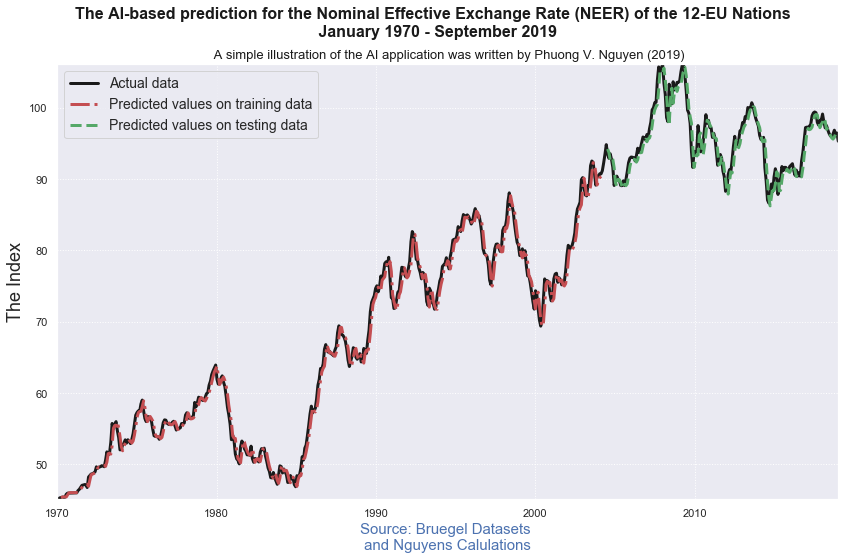

In [185]:
sns.set()
fig=plt.figure(figsize=(14,8))
plt.plot(time,NEER_EA12,LineWidth=3,Color='k',
        label='Actual data')
plt.plot(time[3:len(train)],trainPredict,LineStyle='-.',LineWidth=3,Color='r',
        label='Predicted values on training data')
plt.plot(time[len(train)+3:len(dataset)],testPredict,LineStyle='--',LineWidth=3,Color='g',
        label='Predicted values on testing data')
plt.autoscale(enable=True,axis='both',tight=True)
plt.grid(linestyle=':',which='major',linewidth=1)
fig.suptitle('The AI-based prediction for the Nominal Effective Exchange Rate (NEER) of the 12-EU Nations \n January 1970 - September 2019'
             ,fontsize=16,fontweight='bold',color='k')
plt.title('  \n A simple illustration of the AI application was written by Phuong V. Nguyen (2019)'
          ,fontsize=13,fontweight='normal',color='k')
plt.ylabel('The Index',fontsize=18)
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Source: Bruegel Datasets \n and Nguyen''s Calulations ' ,
           fontsize=15,fontweight='ultralight',color='b')

In [182]:
import math
trainScore = model.evaluate(train_X, train_Y, verbose=0)
print( 'Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_X, test_y, verbose=0)
print( 'Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 1.38 MSE (1.18 RMSE)
Test Score: 2.21 MSE (1.49 RMSE)


In [ ]:
input_x = data[-n_steps:, 0]

In [ ]:
data_in=train.iloc()

In [189]:
len(train)

417

In [190]:
train.

<bound method NDFrame.tail of 0      45.137171
1      45.171406
2      45.305644
3      45.361878
4      45.419130
         ...    
412    90.421713
413    90.383080
414    90.746473
415    90.728379
416    91.173592
Name: NEER_38_EA12, Length: 417, dtype: float64>

In [226]:
thu=train[414:417]

In [228]:
thu=array(thu)

In [229]:
thu

array([90.74647287, 90.72837864, 91.17359202])

In [232]:
thu.reshape(1,3)

array([[90.74647287, 90.72837864, 91.17359202]])

In [195]:
#history= [x for x in train]

In [204]:
#input=history[-n_steps:,0]

In [234]:
#yhat=model.predict(thu)

In [231]:
thu.shape

(3,)